In [1]:
#optiver volatility prediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/train.csv')
test = pd.read_csv('/Users/ericp/OneDrive/Documents/GitHub/Optiver/test.csv')
order_book = pq.read_table('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/stock_id=0/').to_pandas()
trade_book = pq.read_table('/Users/ericp/OneDrive/Documents/GitHub/Optiver/trade_train.parquet/stock_id=0/').to_pandas()
order_book['stock_id'] = 0
trade_book['stock_id'] = 0

In [4]:
order_book = order_book[order_book['time_id'] == 5]
trade_book = trade_book[trade_book['time_id'] == 5]

In [5]:
print('train has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
print('order_book has {} rows and {} columns'.format(order_book.shape[0], order_book.shape[1]))
print('trade_book has {} rows and {} columns'.format(trade_book.shape[0], trade_book.shape[1]))

train has 428932 rows and 3 columns
test has 3 rows and 3 columns
order_book has 302 rows and 11 columns
trade_book has 40 rows and 6 columns


In [8]:
train.head(10)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
5,0,72,0.004912
6,0,97,0.009388
7,0,103,0.004120
8,0,109,0.002182
9,0,123,0.002669


In [7]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [9]:
order_book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [10]:
trade_book.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [11]:
order_book['wt_avg'] = (order_book['bid_price1'] * order_book['ask_size1'] + order_book['ask_price1'] *
                        order_book['bid_size1']) / (order_book['bid_size1'] + order_book['ask_size1'])

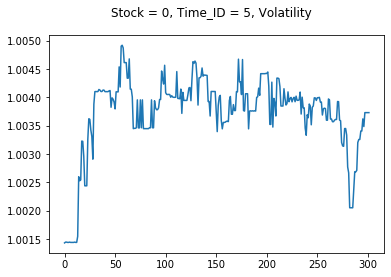

In [12]:
fig,axs = plt.subplots(1)
fig.suptitle('Stock = 0, Time_ID = 5, Volatility')
axs.plot(order_book['wt_avg'])

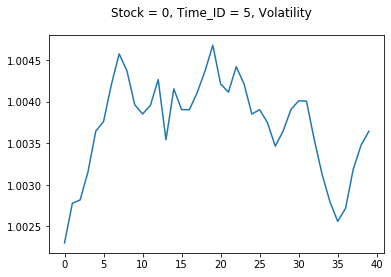

In [13]:
fig,axs = plt.subplots(1)
fig.suptitle('Stock = 0, Time_ID = 5, Volatility')
axs.plot(trade_book['price'])

In [14]:
def logDiff(stock_prices):
    return np.log(stock_prices).diff()

In [15]:
order_book['logDifferences'] = logDiff(order_book['wt_avg'])
order_book = order_book[order_book['logDifferences'].notnull()]
trade_book['logDifferences'] = logDiff(trade_book['price'])
trade_book = trade_book[trade_book['logDifferences'].notnull()]

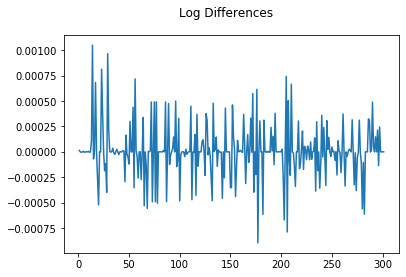

In [16]:
fig, axs = plt.subplots(1)
fig.suptitle('Log Differences')
axs.plot(order_book['logDifferences'])

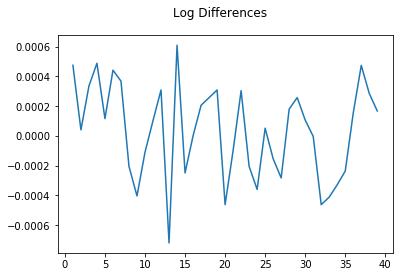

In [17]:
fig, axs = plt.subplots(1)
fig.suptitle('Log Differences')
axs.plot(trade_book['logDifferences'])

In [19]:
def realized_vol(log_diffs):
    return np.sqrt(np.sum(log_diffs ** 2))

In [20]:
print('Realized vol for Stock 0 over Time Period 5 order_book is: {}'.format(realized_vol(order_book['logDifferences'])))
print('Realized vol for Stock 0 over Time Period 5 trade_book is: {}'.format(realized_vol(trade_book['logDifferences'])))

Realized vol for Stock 0 over Time Period 5 order_book is: 0.004499364172786558
Realized vol for Stock 0 over Time Period 5 trade_book is: 0.0020058895461261272


In [21]:
def RMSPE(vols, truth):         
    return np.sqrt(np.sum(np.mean(np.square((vols - truth)/truth))))

In [22]:
orderPath = glob.glob('/Users/ericp/OneDrive/Documents/GitHub/Optiver/book_train.parquet/*')
predictionColumn = 'target'

In [36]:
def orderBookVol(path, predictionColumn):
    order = pq.read_table(path).to_pandas()
    x = int(path.split('=')[1])
    order['stock_id'] = str(x)
    order['time_id'] = order['time_id'].apply(str)
    order['row_id'] = order['stock_id'] + '-' + order['time_id']
    order['wt_avg'] = (order['bid_price1'] * order['ask_size1'] + order['ask_price1'] * 
                        order['bid_size1']) / (order['bid_size1'] + order['ask_size1'])
    order['logDifferences'] = order.groupby(['time_id'])['wt_avg'].apply(logDiff)
    order = order[order['logDifferences'].notnull()]
    realized_vols =  pd.DataFrame(order.groupby(['row_id'])['logDifferences'].agg(realized_vol)).reset_index()
    realized_vols = realized_vols.rename(columns = {'logDifferences': predictionColumn})
    realized_vols = realized_vols[['row_id', 'target']]
    return realized_vols

In [37]:
ans = orderBookVol(orderPath[0], predictionColumn)

KeyError: "['row_id'] not in index"

In [35]:
ans

,row_id,target
0,0-1000,0.001731
1,0-10000,0.002863
2,0-10005,0.008673
3,0-10017,0.014300
4,0-10030,0.002503
...,...,...
3825,0-9972,0.004021
3826,0-9973,0.010147
3827,0-9976,0.006583
3828,0-9988,0.003195


In [24]:
#loop thorugh all of the books:
response = pd.DataFrame()
for file in orderPath:
    response = pd.concat([response, orderBookVol(file, predictionColumn)], axis = 0)    

In [28]:
ans = pd.DataFrame(columns=['row_id', 'target'])

In [29]:
ans

,row_id,target
